In [17]:
import praw
import cPickle as pickle
import os
import nltk
from nltk.corpus import stopwords
from __future__ import division
import string
import re
import math
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from matplotlib import pyplot
%matplotlib inline

Getting data from reddit

In [ ]:
r = praw.Reddit(user_agent='m')

In [ ]:
community = "christianity"
submissions = r.get_subreddit(community).get_top_from_all(limit=1000)

In [ ]:
count = 0
raw_text = ""
for submission in submissions:
    if count % 10 == 0:
        print "%d%% done" % (count/10)
    try:
        raw_text += " " + submission.title
        for c in submission.comments:
            raw_text += " " + c.body
    except:
        continue
    count += 1    

In [ ]:
afile = open(r'.\christianity_content.pkl', 'wb')
pickle.dump(raw_text, afile)
afile.close()

In [ ]:
community = "islam"
submissions = r.get_subreddit(community).get_top_from_all(limit=1000)

In [ ]:
count = 0
raw_text = ""
for submission in submissions:
    if count % 10 == 0:
        print "%d%% done" % (count/10)
    try:
        raw_text += " " + submission.title
        for c in submission.comments:
            raw_text += " " + c.body
    except:
        continue
    count += 1  

In [ ]:
afile = open(r'.\islam_content.pkl', 'wb')
pickle.dump(raw_text, afile)
afile.close()

In [ ]:
communities = ["sports", "gaming", "movies", "music"]

community_submissions = {}
for community in communities:
    community_submissions[community] = r.get_subreddit(community).get_top_from_all(limit=800)

In [ ]:
for community, submissions in community_submissions.items():
    count = 0
    raw_text = ""
    for submission in submissions:
        if count % 10 == 0:
            print "%d%% done" % (count/10)
        try:
            raw_text += " " + submission.title
            for c in submission.comments:
                raw_text += " " + c.body
        except:
            continue
        count += 1  
        
    afile = open(r'.\\'+ community +'_content.pkl', 'wb')
    pickle.dump(raw_text, afile)
    afile.close()

In [ ]:
afile = open(r'.\islam_content.pkl', 'wb')
pickle.dump(raw_text, afile)
afile.close()

Load saved text from subreddits

In [13]:
subreddits = ["sports", "gaming", "movies", "music","islam","christianity"]
subreddit_rawtext = {}

for subreddit in subreddits:
    afile = open(r'.\\'+subreddit+'_content.pkl', 'rb')
    subreddit_rawtext[subreddit] = pickle.load(afile)
    afile.close()


Tokenizing text

In [18]:
# dictionary mapping subreddit -> cleaned token list
subreddit_cleantokens = {}

# stopwords (to be removed from tokens)
stopwords = nltk.corpus.stopwords.words('english')

# common words
common_words = ["n't","''",'""',"``","i","'s","'m","...","the","it","i",'this']

# combine all words to remove to reduce iterations
remove = list(string.punctuation) + stopwords + common_words

wnl = WordNetLemmatizer()
        
for subreddit, rawtext in subreddit_rawtext.items():
    tokens = nltk.word_tokenize(rawtext)
    tokens = [w for w in tokens if w not in remove] # remove unwanted words
    tokens = [w for w in tokens if not re.match(r'^[-+]?(\d+(.\d+)?)$', w)] # remove all numbers 
    tokens = [w.lower() for w in tokens] # make lower-case
    tokens = [wnl.lemmatize(w) for w in tokens]

    subreddit_cleantokens[subreddit] = tokens
    
subreddit_cleantokens["islam_christianity"] = subreddit_cleantokens["islam"] + subreddit_cleantokens["christianity"]

Calculating TF

In [19]:
# resulting TFs: branch -> (word -> frequency in branch)
subreddit_tfs = {}

# compute freqdist for each branch
for subreddit, wordlist in subreddit_cleantokens.items():
    subreddit_tfs[subreddit] = nltk.FreqDist(wordlist)   
    
# print top five occuring words in each branch
template = "{0:37}|{1:10}"
print "TOP FIVE TERMS IN EACH SUBREDDIT"
for subreddit, tfs in subreddit_tfs.items():
    top_five = sorted(tfs.items(), key = lambda (w, c) : (-c, w))[:10]
    print template.format(subreddit, ', '.join([w for w,c in top_five]))

TOP FIVE TERMS IN EACH SUBREDDIT
gaming                               |i, game, like, http, one, the, would, get, this, it
islam_christianity                   |i, god, people, like, christian, one, it, the, would, think
christianity                         |i, god, people, christian, like, one, it, church, would, the
movies                               |i, movie, the, like, http, one, film, it, would, see
music                                |i, http, song, like, the, //www.youtube.com/watch, one, music, time, album
sports                               |i, like, http, the, game, one, would, guy, get, it
islam                                |i, muslim, people, allah, like, one, islam, http, the, would


Run this first to calculate TFIDFs for Christianity

In [35]:
subbreddits_considered = ["sports", "gaming", "movies", "music", "christianity"]

Run this first to calculate TFIDFs for Islam

In [34]:
subbreddits_considered = ["sports", "gaming", "movies", "music", "islam"]

Run this first to calculate TFIDFs for Islam+Christianity combined

In [ ]:
subbreddits_considered = ["sports", "gaming", "movies", "music", "islam_christianity"]

Calculating IDFs

In [36]:
cleaned_tokens = {subreddit:tokens for subreddit,tokens in subreddit_cleantokens.items() if subreddit in subbreddits_considered}

In [37]:
# resulting IDFs: word -> idf
word_idfs = {}

# list where a token appears once for every branch it appears in i.e. values 1-6 times
all_words = []
for wordlist in cleaned_tokens.values():
    all_words += set(wordlist)

# word -> num branches it's in
word_freq = nltk.FreqDist(all_words)

# compute idf for every word
num_subreddits = len(cleaned_tokens.values()) # obviously 2 here, but rather not hard-code
for word in set(all_words):
    idf = math.log(num_subreddits / word_freq[word])
    word_idfs[word] = idf

Calculating TFIDF

In [38]:
# resulting TF-IDFs: branch -> (word -> tf-idf)
subreddit_tfidfs = {}

In [39]:

# compute TF-IDF for each word, for each branch
for subreddit, wordlist in cleaned_tokens.items():
    tfidfs = {word: subreddit_tfs[subreddit][word] * word_idfs[word] for word in wordlist}
    subreddit_tfidfs[subreddit] = tfidfs
    
# print top 10 words in each branch
template = "{0:34}\n\t|{1:10}\n"
print "TOP TEN WORDS IN EACH SUBREDDIT"
for subreddit, tfidfs in subreddit_tfidfs.items():
    top_ten = sorted(tfidfs.items(), key = lambda (w, c) : (-c, w))[:10]
    print template.format(subreddit, ', '.join([w.encode('utf8') for w,c in top_ten]))

TOP TEN WORDS IN EACH SUBREDDIT
gaming                            
	|gemle, modders, bethesda, iwata, controller, fallout, witcher, ps4, cartridge, npc

sports                            
	|rugby, nba, sportscenter, playoff, mayweather, espn, dunk, jeter, ronaldo, seahawks

movies                            
	|imax, ultron, cgi, spielberg, tarantino, 288i, ebert, blofeld, cumberbatch, depp

music                             
	||**https, foo, /r/music, coheed, deftones, ticketmaster, grooveshark, nujabes, musician, metallica

christianity                      
	|pastor, /r/christianity, r/christianity, baptized, scripture, denomination, /r/atheism, baptism, gospel, sinful



In [40]:
top_c = {w:c for w,c in sorted(subreddit_tfidfs["christianity"].items(), key = lambda (w, c) : (-c, w))[:1000]}
top_i = {w:c for w,c in sorted(subreddit_tfidfs["islam"].items(), key = lambda (w, c) : (-c, w))[:1000]}

top_c = {w:c for w,c in top_c.items() if w in top_i.keys()}
top_i = {w:c for w,c in top_i.items() if w in top_c.keys()}
incommon = top_i.keys()
incommon_scores_added = {w:c + top_i[w] for w,c in top_c.items()}
incommon_scores_difference = {w:abs(c - top_i[w]) for w,c in top_c.items()}

top_added = sorted(incommon_scores_added.items(), key = lambda (w, c) : (-c, w))[:50]
# words that both groups have the most similarity in significance
top_difference = sorted(incommon_scores_added.items(), key = lambda (w, c) : (c, w))[:50]
print incommon[:50]
print
print [w for w,c in top_added]
print
print [w for w,c in top_difference]

KeyError: 'islam'

In [46]:
tfidfs_to_show = {}
#tfidfs_to_show["Islam"] = subreddit_tfidfs["islam"]
tfidfs_to_show["Christianity"] = subreddit_tfidfs["christianity"]
#tfidfs_to_show["Added Scores"] = incommon_scores_added
#tfidfs_to_show["Difference of Scores"] = incommon_scores_difference
#tfidfs_to_show["Combined"] = subreddit_tfidfs["islam_christianity"]
#tfidfs_to_show["In Common"] = {w:1 for w in top_i}

# resulting strings: branch -> wordlist
subreddit_tfidfs_strings = {}
#subreddit_tfidfs_strings["InCommon"] = ' '.join(incommon)

print subreddit_tfidfs["christianity"]["r/christianity"] 

# each list contains a word as many times as its TF-IDF score
for subreddit, tfidfs in tfidfs_to_show.items():
    tfidf_list = []
    for word, score in tfidfs.items():
        int_score = int((math.ceil(score))) # score rounded to an integer
        if word == "islam":
            int_score = 500
        if word == "non":
            int_score = 500
        tfidf_list += [word] * int_score 
        
    subreddit_tfidfs_strings[subreddit] = ' '.join(tfidf_list) # create one string

455.470929219


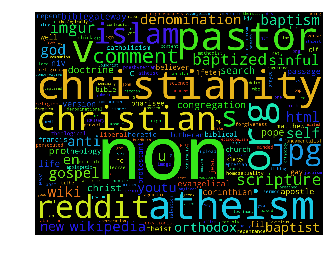

In [47]:
p = 0
for subreddit, text in subreddit_tfidfs_strings.items():
    wordcloud = WordCloud(width=1800,height=1400).generate(text)
    pyplot.figure()
    pyplot.imshow(wordcloud)
    pyplot.axis("off")
    #pyplot.title(subreddit.upper())
    pyplot.savefig('./'+subreddit+'_wordclouds.png', dpi=300)
    pyplot.show()

#pyplot.savefig('./branch_wordclouds.png', dpi=300)

In [54]:
from scipy.misc import imread

reddit_mask = imread('./reddit-mask.png', flatten=True)


for subreddit, text in subreddit_tfidfs_strings.items():
    if subreddit == "Christianity" or subreddit == "Islam":
        continue
    wordcloud = WordCloud(
                      max_font_size=200,
                      background_color='white',
                      mask=reddit_mask
            ).generate(text)
    pyplot.figure()
    pyplot.imshow(wordcloud)
    pyplot.axis("off")
    #pyplot.title(subreddit.upper())
    pyplot.savefig('./'+subreddit+'_wordclouds.png', dpi=300)
    pyplot.show()

TypeError: coercing to Unicode: need string or buffer, list found

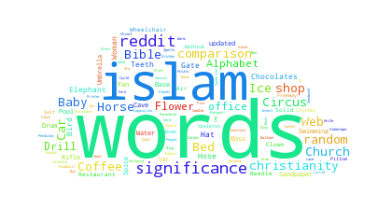

In [59]:
from scipy.misc import imread

reddit_mask = imread('./cloud_mask.png', flatten=True)

text = """Random Word List

Print this page, cut out the words, put them in a jar, and use it to draw out random words when you need a stimulus.
Adult

Aeroplane

Air

Aircraft Carrier

Airforce

Airport

Album

Alphabet

Apple

Arm

Army

Baby

Baby

Backpack

Balloon

Banana

Bank

Barbecue

Bathroom

Bathtub

Bed

Bed

Bee

Bible

Bible

Bird

Bomb

Book

Boss

Bottle

Bowl

Box

Boy

Brain

Bridge

Butterfly

Button

Cappuccino

Car

Car-race

Carpet

Carrot

Cave

Chair

Chess Board

Chief

Child

Chisel

Chocolates

Church

Church

Circle

Circus

Circus

Clock

Clown

Coffee

Coffee-shop

Comet

Compact Disc

Compass

Computer

Crystal

Cup

Cycle

Data Base

Desk

Diamond

Dress

Drill

Drink

Drum

Dung

Ears

Earth

Egg

Electricity

Elephant

Eraser

Explosive

Eyes

Family

Fan

Feather

Festival

Film

Finger

Fire

Floodlight

Flower

Foot

Fork

Freeway

Fruit

Fungus

Game

Garden

Gas

Gate

Gemstone

Girl

Gloves

God

Grapes

Guitar

Hammer

Hat

Hieroglyph

Highway

Horoscope

Horse

Hose

Ice

Ice-cream

Insect

Jet fighter

Junk

Kaleidoscope

Kitchen

Knife

Leather jacket

Leg

Library

Liquid

Magnet

Man

Map

Maze

Meat

Meteor

Microscope

Milk

Milkshake

Mist

Money $$$$

Monster

Mosquito

Mouth

Nail

Navy

Necklace

Needle

Onion

PaintBrush

Pants

Parachute

Passport

Pebble

Pendulum

Pepper

Perfume

Pillow

Plane

Planet

Pocket

Post-office

Potato

Printer

Prison

Pyramid

Radar

Rainbow

Record

Restaurant

Rifle

Ring

Robot

Rock

Rocket

Roof

Room

Rope

Saddle

Salt

Sandpaper

Sandwich

Satellite

School

Sex

Ship

Shoes

Shop

Shower

Signature

Skeleton

Slave

Snail

Software

Solid

Space Shuttle

Spectrum

Sphere

Spice

Spiral

Spoon

Sports-car

Spot Light

Square

Staircase

Star

Stomach

Sun

Sunglasses

Surveyor

Swimming Pool

Sword

Table

Tapestry

Teeth

Telescope

Television

Tennis racquet

Thermometer

Tiger

Toilet

Tongue

Torch

Torpedo

Train

Treadmill

Triangle

Tunnel

Typewriter

Umbrella

Vacuum

Vampire

Videotape

Vulture

Water

Weapon

Web

Wheelchair

Window

Woman

Worm

X-ray


Last updated"""
text = text.split()
text += ["words"] *50
text += ["reddit"] *50
text += ["christianity"] *50
text += ["islam"] *50
text += ["significance"] *50
text += ["comparison"] *50
text = ' '.join(text)
wordcloud = WordCloud(max_font_size=200,background_color='white',mask=reddit_mask).generate(text)
#wordcloud = WordCloud(width=1800,height=1400).generate(text)
pyplot.figure()
pyplot.imshow(wordcloud)
pyplot.axis("off")
#pyplot.title(subreddit.upper())
pyplot.savefig('./cloud_wordclouds.png', dpi=300)
pyplot.show()

In [ ]:
print len(subreddit_tfidfs_strings["Christianity"])